<a href="https://colab.research.google.com/github/jayanthbagare/hackfest_analysis/blob/main/DataCleaning%26Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### NB: Take the Scoring Sheet and Consolidated Sheet as file1.csv and file2.csv respectively.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [90]:
def merge_csv_files(file1_path, file2_path, output_path, merge_strategy='inner'):
    """
    Merge two CSV files based on common columns.

    Parameters:
    file1_path (str): Path to the first CSV file (with player data)
    file2_path (str): Path to the second CSV file (with team metadata)
    output_path (str): Path for the merged output CSV file
    merge_strategy (str): 'left', 'right', 'inner', or 'outer'
    """

    try:
        # Read the CSV files
        print("Reading CSV files...")
        df1 = pd.read_csv(file1_path)
        df2 = pd.read_csv(file2_path)

        print(f"File 1 shape: {df1.shape}")
        print(f"File 2 shape: {df2.shape}")

        # Display first few rows to understand the data
        # print("\nFirst few rows of File 1:")
        # print(df1.head())
        # print("\nFirst few rows of File 2:")
        # print(df2.head())

        # Clean column names (remove extra spaces)
        df1.columns = df1.columns.str.strip()
        df2.columns = df2.columns.str.strip()

        merged_df = pd.merge(df1, df2, on=['College_Name', 'Team_Name'], how=merge_strategy)
        print(merged_df.info())
        merged_df.to_csv(output_path)
    except Exception as e:
      print(f"Error occurred: {str(e)}")
      return None



In [91]:
# Example usage
if __name__ == "__main__":
    # Basic merge
    file1_path = "file1.csv"  # Replace with your first CSV file path
    file2_path = "file2.csv"  # Replace with your second CSV file path
    output_path = "merged_file.csv"

    merged_data = merge_csv_files(file1_path, file2_path, output_path, merge_strategy='inner')
    print("\nMerge completed successfully!")

Reading CSV files...
File 1 shape: (3504, 10)
File 2 shape: (2968, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UUID              785 non-null    object 
 1   Team_Name         785 non-null    object 
 2   Team_Size         785 non-null    int64  
 3   City              785 non-null    object 
 4   College_Name      785 non-null    object 
 5   Degree            785 non-null    object 
 6   Department        785 non-null    object 
 7   Theme             785 non-null    object 
 8   Ideal_Title       0 non-null      float64
 9   Idea_Description  0 non-null      float64
 10  P1_Name           693 non-null    object 
 11  P2_Name           579 non-null    object 
 12  P1_Role           693 non-null    object 
 13  P2_Role           579 non-null    object 
 14  P1_Q1             784 non-null    object 
 15  P1_Q2             78

In [92]:
class HackathonAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with the CSV file path"""
        self.csv_file_path = csv_file_path
        self.df = None
        self.question_mapping = {
            'Q1': 'Theme Relevance',
            'Q2': 'Problem Solving Impact',
            'Q3': 'Originality',
            'Q4': 'Market Disruption Potential',
            'Q5': 'Implementation Feasibility',
            'Q6': 'Prototype Development',
            'Q7': 'Problem Significance',
            'Q8': 'Long-term Impact'
        }

    def load_and_clean_data(self):
        """Load the CSV file and perform initial data cleaning"""
        print("Loading and cleaning data...")
        try:
            self.df = pd.read_csv(self.csv_file_path)
            print(f"Data loaded successfully. Shape: {self.df.shape}")

            # Display basic info
            print("\nColumn names:")
            print(self.df.columns.tolist())

            # Check for missing values
            print("\nMissing values before cleaning:")
            missing_values = self.df.isnull().sum()
            print(missing_values[missing_values > 0])

            # Clean and convert question columns to numeric
            question_columns = []
            for participant in ['P1', 'P2']:
                for q_num in range(1, 9):
                    col_name = f'{participant}_Q{q_num}'
                    if col_name in self.df.columns:
                        question_columns.append(col_name)

            print(f"\nCleaning question columns: {question_columns}")

            # Convert question columns to numeric, handling errors
            for col in question_columns:
                print(f"Processing {col}...")
                # First, let's see what values are in this column
                unique_vals = self.df[col].unique()
                print(f"  Unique values in {col}: {unique_vals}")

                # Convert to numeric, coerce errors to NaN
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

                # Fill NaN values with 0 (assuming missing ratings = 0)
                nan_count = self.df[col].isnull().sum()
                if nan_count > 0:
                    print(f"  Found {nan_count} non-numeric values in {col}, replacing with 0")
                    self.df[col] = self.df[col].fillna(0)

                # Ensure values are within valid range (0-2)
                invalid_range = ((self.df[col] < 0) | (self.df[col] > 2)).sum()
                if invalid_range > 0:
                    print(f"  Found {invalid_range} values outside 0-2 range in {col}, clipping to range")
                    self.df[col] = self.df[col].clip(0, 2)

            # Clean Team_Size if it exists
            if 'Team_Size' in self.df.columns:
                self.df['Team_Size'] = pd.to_numeric(self.df['Team_Size'], errors='coerce')
                self.df['Team_Size'] = self.df['Team_Size'].fillna(2)  # Default team size = 2

            # Clean string columns by removing extra whitespace
            string_columns = ['Team_Name', 'City', 'College_Name', 'Department', 'Theme',
                            'Ideal_Title', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role']

            for col in string_columns:
                if col in self.df.columns:
                    self.df[col] = self.df[col].astype(str).str.strip()
                    # Replace empty strings with 'Unknown'
                    self.df[col] = self.df[col].replace(['', 'nan', 'None'], 'Unknown')

            print("\nData cleaning completed!")
            print("Final missing values:")
            missing_values_final = self.df.isnull().sum()
            print(missing_values_final[missing_values_final > 0])

            # Verify question columns are now numeric
            print("\nQuestion column data types after cleaning:")
            for col in question_columns:
                if col in self.df.columns:
                    print(f"  {col}: {self.df[col].dtype}, range: {self.df[col].min():.1f}-{self.df[col].max():.1f}")

            return True

        except FileNotFoundError:
            print(f"Error: File '{self.csv_file_path}' not found.")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            print("Full error details:")
            import traceback
            traceback.print_exc()
            return False

    def calculate_scores(self):
        """Calculate individual and team scores"""
        print("\nCalculating scores...")

        # Define question columns for P1 and P2 (only include columns that exist)
        p1_questions = [f'P1_Q{i}' for i in range(1, 9) if f'P1_Q{i}' in self.df.columns]
        p2_questions = [f'P2_Q{i}' for i in range(1, 9) if f'P2_Q{i}' in self.df.columns]

        print(f"P1 question columns found: {p1_questions}")
        print(f"P2 question columns found: {p2_questions}")

        # Verify all columns are numeric
        for col in p1_questions + p2_questions:
            if not pd.api.types.is_numeric_dtype(self.df[col]):
                print(f"Warning: {col} is not numeric type: {self.df[col].dtype}")
                # Try to convert again
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)

        # Calculate individual scores only if columns exist
        if p1_questions:
            self.df['P1_Total_Score'] = self.df[p1_questions].sum(axis=1)
            print(f"P1 total score range: {self.df['P1_Total_Score'].min():.1f} - {self.df['P1_Total_Score'].max():.1f}")
        else:
            print("No P1 question columns found!")
            self.df['P1_Total_Score'] = 0

        if p2_questions:
            self.df['P2_Total_Score'] = self.df[p2_questions].sum(axis=1)
            print(f"P2 total score range: {self.df['P2_Total_Score'].min():.1f} - {self.df['P2_Total_Score'].max():.1f}")
        else:
            print("No P2 question columns found!")
            self.df['P2_Total_Score'] = 0

        # Calculate team average score
        self.df['Team_Average_Score'] = (self.df['P1_Total_Score'] + self.df['P2_Total_Score']) / 2

        # Calculate question-wise team averages
        for i in range(1, 9):
            p1_col = f'P1_Q{i}'
            p2_col = f'P2_Q{i}'

            if p1_col in self.df.columns and p2_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = (self.df[p1_col] + self.df[p2_col]) / 2
            elif p1_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = self.df[p1_col]  # Use only P1 if P2 missing
                print(f"Warning: Using only P1 score for Q{i}")
            elif p2_col in self.df.columns:
                self.df[f'Team_Q{i}_Avg'] = self.df[p2_col]  # Use only P2 if P1 missing
                print(f"Warning: Using only P2 score for Q{i}")
            else:
                self.df[f'Team_Q{i}_Avg'] = 0  # Default to 0 if both missing
                print(f"Warning: Both P1 and P2 missing for Q{i}, using 0")

        print(f"Team average score range: {self.df['Team_Average_Score'].min():.1f} - {self.df['Team_Average_Score'].max():.1f}")
        print("Scores calculated successfully!")

    def basic_statistics(self):
        """Generate basic statistical summary"""
        print("\n" + "="*50)
        print("BASIC STATISTICS")
        print("="*50)

        # Overall statistics
        print(f"Total number of teams: {len(self.df)}")
        print(f"Total number of participants: {len(self.df) * 2}")  # Assuming 2 people per team

        # Team size distribution
        if 'Team_Size' in self.df.columns:
            print(f"\nTeam size distribution:")
            print(self.df['Team_Size'].value_counts().sort_index())

        # City distribution
        if 'City' in self.df.columns:
            print(f"\nTop 10 cities by participation:")
            print(self.df['City'].value_counts().head(10))

        # College distribution
        if 'College_Name' in self.df.columns:
            print(f"\nTop 10 colleges by participation:")
            print(self.df['College_Name'].value_counts().head(10))

        # Theme distribution
        if 'Theme' in self.df.columns:
            print(f"\nTheme distribution:")
            print(self.df['Theme'].value_counts())

        # Department distribution
        if 'Department' in self.df.columns:
            print(f"\nTop 10 departments:")
            print(self.df['Department'].value_counts().head(10))

    def score_analysis(self):
        """Analyze scoring patterns"""
        print("\n" + "="*50)
        print("SCORE ANALYSIS")
        print("="*50)

        # Overall score statistics
        print("Team Average Score Statistics:")
        print(f"Mean: {self.df['Team_Average_Score'].mean():.2f}")
        print(f"Median: {self.df['Team_Average_Score'].median():.2f}")
        print(f"Std Dev: {self.df['Team_Average_Score'].std():.2f}")
        print(f"Min: {self.df['Team_Average_Score'].min():.2f}")
        print(f"Max: {self.df['Team_Average_Score'].max():.2f}")

        # Question-wise analysis
        print(f"\nQuestion-wise Team Average Scores:")
        for i in range(1, 9):
            col = f'Team_Q{i}_Avg'
            question_name = self.question_mapping[f'Q{i}']
            mean_score = self.df[col].mean()
            print(f"Q{i} ({question_name}): {mean_score:.2f}")

        # Top performing teams
        print(f"\nTop 10 performing teams:")
        top_teams = self.df.nlargest(10, 'Team_Average_Score')[['Team_Name', 'Team_Average_Score', 'City', 'College_Name']]
        print(top_teams.to_string(index=False))

    def inter_rater_reliability(self):
        """Analyze agreement between P1 and P2 ratings"""
        print("\n" + "="*50)
        print("INTER-RATER RELIABILITY ANALYSIS")
        print("="*50)

        correlations = []
        valid_questions = []

        for i in range(1, 9):
            p1_col = f'P1_Q{i}'
            p2_col = f'P2_Q{i}'

            # Only calculate correlation if both columns exist and have data
            if p1_col in self.df.columns and p2_col in self.df.columns:
                # Check if there's any variation in the data
                if self.df[p1_col].std() > 0 and self.df[p2_col].std() > 0:
                    correlation = self.df[p1_col].corr(self.df[p2_col])
                    if not pd.isna(correlation):
                        correlations.append(correlation)
                        valid_questions.append(i)
                        question_name = self.question_mapping[f'Q{i}']
                        print(f"Q{i} ({question_name}): r = {correlation:.3f}")
                    else:
                        print(f"Q{i}: Unable to calculate correlation (insufficient data variation)")
                else:
                    print(f"Q{i}: No variation in scores, correlation not meaningful")
            else:
                print(f"Q{i}: Missing P1 or P2 data, skipping correlation")

        if correlations:
            print(f"\nOverall average correlation: {np.mean(correlations):.3f}")
            print(f"Based on {len(correlations)} valid question pairs")

            # Calculate overall correlation between P1 and P2 total scores
            if 'P1_Total_Score' in self.df.columns and 'P2_Total_Score' in self.df.columns:
                if self.df['P1_Total_Score'].std() > 0 and self.df['P2_Total_Score'].std() > 0:
                    overall_corr = self.df['P1_Total_Score'].corr(self.df['P2_Total_Score'])
                    if not pd.isna(overall_corr):
                        print(f"Overall total score correlation: {overall_corr:.3f}")
                    else:
                        print("Overall total score correlation: Unable to calculate")
        else:
            print("No valid correlations could be calculated")

    def theme_analysis(self):
        """Analyze performance by theme"""
        if 'Theme' not in self.df.columns:
            print("Theme column not found, skipping theme analysis")
            return

        print("\n" + "="*50)
        print("THEME-WISE ANALYSIS")
        print("="*50)

        theme_stats = self.df.groupby('Theme').agg({
            'Team_Average_Score': ['count', 'mean', 'std'],
            'Team_Q1_Avg': 'mean',  # Theme relevance
            'Team_Q2_Avg': 'mean',  # Problem solving
            'Team_Q3_Avg': 'mean',  # Originality
            'Team_Q4_Avg': 'mean'   # Market disruption
        }).round(2)

        print("Theme-wise statistics:")
        print(theme_stats)

    def college_analysis(self):
        """Analyze performance by college"""
        if 'College_Name' not in self.df.columns:
            print("College_Name column not found, skipping college analysis")
            return

        print("\n" + "="*50)
        print("COLLEGE PERFORMANCE ANALYSIS")
        print("="*50)

        # Only analyze colleges with more than 2 teams
        college_stats = self.df.groupby('College_Name').agg({
            'Team_Average_Score': ['count', 'mean', 'std'],
        }).round(2)

        college_stats = college_stats[college_stats[('Team_Average_Score', 'count')] > 2]
        college_stats = college_stats.sort_values(('Team_Average_Score', 'mean'), ascending=False)

        print("Top colleges by average performance (min 3 teams):")
        print(college_stats.head(10))

    def clustering_analysis(self):
        """Perform clustering analysis on teams"""
        print("\n" + "="*50)
        print("CLUSTERING ANALYSIS")
        print("="*50)

        # Prepare data for clustering
        cluster_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
        cluster_data = self.df[cluster_cols].fillna(self.df[cluster_cols].mean())

        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cluster_data)

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        self.df['Cluster'] = kmeans.fit_predict(scaled_data)

        # Analyze clusters
        print("Cluster analysis (4 clusters):")
        cluster_analysis = self.df.groupby('Cluster').agg({
            'Team_Average_Score': ['count', 'mean'],
            **{f'Team_Q{i}_Avg': 'mean' for i in range(1, 9)}
        }).round(2)

        print(cluster_analysis)

        # Label clusters based on characteristics
        cluster_labels = {
            0: "Cluster 0",
            1: "Cluster 1",
            2: "Cluster 2",
            3: "Cluster 3"
        }

        for cluster_id in range(4):
            cluster_data = self.df[self.df['Cluster'] == cluster_id]
            avg_score = cluster_data['Team_Average_Score'].mean()
            team_count = len(cluster_data)

            print(f"\n{cluster_labels[cluster_id]}: {team_count} teams, Avg Score: {avg_score:.2f}")

    def generate_visualizations(self):
        """Generate comprehensive visualizations"""
        print("\n" + "="*50)
        print("GENERATING VISUALIZATIONS")
        print("="*50)

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 24))

        # 1. Score distribution
        plt.subplot(4, 3, 1)
        plt.hist(self.df['Team_Average_Score'], bins=20, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Team Average Scores')
        plt.xlabel('Average Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 2. Question-wise average scores
        plt.subplot(4, 3, 2)
        question_avgs = [self.df[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]
        question_labels = [f'Q{i}' for i in range(1, 9)]
        bars = plt.bar(question_labels, question_avgs, alpha=0.7)
        plt.title('Average Scores by Question')
        plt.xlabel('Questions')
        plt.ylabel('Average Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, val in zip(bars, question_avgs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2f}', ha='center', va='bottom')

        # 3. Inter-rater correlation heatmap
        plt.subplot(4, 3, 3)
        corr_data = []
        for i in range(1, 9):
            corr_data.append(self.df[f'P1_Q{i}'].corr(self.df[f'P2_Q{i}']))

        corr_matrix = np.array(corr_data).reshape(1, -1)
        sns.heatmap(corr_matrix, annot=True, fmt='.3f',
                   xticklabels=[f'Q{i}' for i in range(1, 9)],
                   yticklabels=['P1 vs P2'], cmap='coolwarm', center=0)
        plt.title('Inter-rater Correlations')

        # 4. Theme distribution (if available)
        if 'Theme' in self.df.columns:
            plt.subplot(4, 3, 4)
            theme_counts = self.df['Theme'].value_counts()
            plt.pie(theme_counts.values, labels=theme_counts.index, autopct='%1.1f%%')
            plt.title('Theme Distribution')

        # 5. City distribution (top 10)
        if 'City' in self.df.columns:
            plt.subplot(4, 3, 5)
            top_cities = self.df['City'].value_counts().head(10)
            plt.barh(range(len(top_cities)), top_cities.values)
            plt.yticks(range(len(top_cities)), top_cities.index)
            plt.title('Top 10 Cities by Participation')
            plt.xlabel('Number of Teams')

        # 6. Score vs Theme (if available)
        if 'Theme' in self.df.columns:
            plt.subplot(4, 3, 6)
            sns.boxplot(data=self.df, x='Theme', y='Team_Average_Score')
            plt.title('Score Distribution by Theme')
            plt.xticks(rotation=45)

        # 7. P1 vs P2 total scores scatter plot
        plt.subplot(4, 3, 7)
        plt.scatter(self.df['P1_Total_Score'], self.df['P2_Total_Score'], alpha=0.6)
        plt.xlabel('P1 Total Score')
        plt.ylabel('P2 Total Score')
        plt.title('P1 vs P2 Total Scores')
        plt.plot([0, 16], [0, 16], 'r--', alpha=0.5)  # Perfect agreement line
        plt.grid(True, alpha=0.3)

        # 8. Question difficulty (based on average scores)
        plt.subplot(4, 3, 8)
        question_difficulty = [(2 - self.df[f'Team_Q{i}_Avg'].mean()) for i in range(1, 9)]
        question_names = [self.question_mapping[f'Q{i}'][:15] + '...' if len(self.question_mapping[f'Q{i}']) > 15
                         else self.question_mapping[f'Q{i}'] for i in range(1, 9)]

        bars = plt.bar(range(8), question_difficulty, alpha=0.7)
        plt.xlabel('Questions')
        plt.ylabel('Difficulty (2 - avg score)')
        plt.title('Question Difficulty Analysis')
        plt.xticks(range(8), [f'Q{i+1}' for i in range(8)], rotation=45)
        plt.grid(True, alpha=0.3)

        # 9. Team size distribution (if available)
        if 'Team_Size' in self.df.columns:
            plt.subplot(4, 3, 9)
            team_size_counts = self.df['Team_Size'].value_counts().sort_index()
            plt.bar(team_size_counts.index, team_size_counts.values, alpha=0.7)
            plt.title('Team Size Distribution')
            plt.xlabel('Team Size')
            plt.ylabel('Number of Teams')
            plt.grid(True, alpha=0.3)

        # 10. Clustering visualization (PCA)
        if 'Cluster' in self.df.columns:
            plt.subplot(4, 3, 10)
            cluster_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
            cluster_data = self.df[cluster_cols].fillna(self.df[cluster_cols].mean())

            pca = PCA(n_components=2)
            pca_data = pca.fit_transform(StandardScaler().fit_transform(cluster_data))

            scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                                c=self.df['Cluster'], cmap='viridis', alpha=0.6)
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('Team Clusters (PCA Visualization)')
            plt.colorbar(scatter)

        # 11. Score correlation matrix
        plt.subplot(4, 3, 11)
        score_cols = [f'Team_Q{i}_Avg' for i in range(1, 9)]
        corr_matrix = self.df[score_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Question Score Correlations')

        # 12. Top vs Bottom performers comparison
        plt.subplot(4, 3, 12)
        top_10_percent = int(len(self.df) * 0.1)
        bottom_10_percent = int(len(self.df) * 0.1)

        top_performers = self.df.nlargest(max(1, top_10_percent), 'Team_Average_Score')
        bottom_performers = self.df.nsmallest(max(1, bottom_10_percent), 'Team_Average_Score')

        top_avgs = [top_performers[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]
        bottom_avgs = [bottom_performers[f'Team_Q{i}_Avg'].mean() for i in range(1, 9)]

        x = np.arange(8)
        width = 0.35

        plt.bar(x - width/2, top_avgs, width, label='Top 10%', alpha=0.8)
        plt.bar(x + width/2, bottom_avgs, width, label='Bottom 10%', alpha=0.8)

        plt.xlabel('Questions')
        plt.ylabel('Average Score')
        plt.title('Top vs Bottom Performers')
        plt.xticks(x, [f'Q{i+1}' for i in range(8)])
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('hackathon_deep_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Comprehensive visualization saved as 'hackathon_analysis_comprehensive.png'")

    def generate_insights(self):
        """Generate key insights and recommendations"""
        print("\n" + "="*60)
        print("KEY INSIGHTS AND RECOMMENDATIONS")
        print("="*60)

        # Performance insights
        mean_score = self.df['Team_Average_Score'].mean()
        std_score = self.df['Team_Average_Score'].std()

        print("📊 PERFORMANCE INSIGHTS:")
        print(f"   • Average team performance: {mean_score:.2f}/2.0 ({mean_score/2*100:.1f}%)")
        print(f"   • Performance variation: σ = {std_score:.2f}")

        # Identify strongest and weakest areas
        question_avgs = [(i, self.df[f'Team_Q{i}_Avg'].mean()) for i in range(1, 9)]
        question_avgs.sort(key=lambda x: x[1], reverse=True)

        strongest_q = question_avgs[0]
        weakest_q = question_avgs[-1]

        print(f"   • Strongest area: Q{strongest_q[0]} ({self.question_mapping[f'Q{strongest_q[0]}']}) - {strongest_q[1]:.2f}")
        print(f"   • Weakest area: Q{weakest_q[0]} ({self.question_mapping[f'Q{weakest_q[0]}']}) - {weakest_q[1]:.2f}")

        # Inter-rater reliability insight
        correlations = [self.df[f'P1_Q{i}'].corr(self.df[f'P2_Q{i}']) for i in range(1, 9)]
        avg_correlation = np.mean(correlations)

        print(f"\n🤝 EVALUATION CONSISTENCY:")
        print(f"   • Average inter-rater correlation: {avg_correlation:.3f}")
        if avg_correlation > 0.7:
            print("   • Excellent agreement between evaluators")
        elif avg_correlation > 0.5:
            print("   • Good agreement between evaluators")
        else:
            print("   • Consider evaluator training for better consistency")

        # Theme insights (if available)
        if 'Theme' in self.df.columns:
            theme_performance = self.df.groupby('Theme')['Team_Average_Score'].mean().sort_values(ascending=False)
            print(f"\n🎯 THEME INSIGHTS:")
            print(f"   • Best performing theme: {theme_performance.index[0]} ({theme_performance.iloc[0]:.2f})")
            print(f"   • Most challenging theme: {theme_performance.index[-1]} ({theme_performance.iloc[-1]:.2f})")

        # Participation insights
        if 'City' in self.df.columns:
            city_participation = self.df['City'].value_counts()
            print(f"\n🌍 PARTICIPATION INSIGHTS:")
            print(f"   • Total cities represented: {len(city_participation)}")
            print(f"   • Highest participation: {city_participation.index[0]} ({city_participation.iloc[0]} teams)")

        if 'College_Name' in self.df.columns:
            college_participation = self.df['College_Name'].value_counts()
            print(f"   • Total colleges represented: {len(college_participation)}")
            print(f"   • Most active college: {college_participation.index[0]} ({college_participation.iloc[0]} teams)")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        print("   1. Focus on improving teams' performance in:", self.question_mapping[f'Q{weakest_q[0]}'])
        print("   2. Use high-performing teams as mentors for improvement areas")

        if avg_correlation < 0.6:
            print("   3. Provide additional training for evaluators to improve consistency")

        print("   4. Consider theme-specific workshops for challenging themes")
        print("   5. Encourage cross-city collaboration to share best practices")

    def export_results(self, filename='hackathon_analysis_results.csv'):
        """Export analyzed data with additional metrics"""
        print(f"\n📁 Exporting results to '{filename}'...")

        # Create export dataframe with original data plus calculated metrics
        export_df = self.df.copy()

        # Add percentile rankings
        export_df['Score_Percentile'] = export_df['Team_Average_Score'].rank(pct=True) * 100

        # Add performance categories
        export_df['Performance_Category'] = pd.cut(
            export_df['Team_Average_Score'],
            bins=[0, 0.8, 1.2, 1.6, 2.0],
            labels=['Needs Improvement', 'Fair', 'Good', 'Excellent']
        )

        export_df.to_csv(filename, index=False)
        print(f"Results exported successfully to '{filename}'")

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Complete Hackathon Analysis")
        print("="*60)

        # Load and clean data
        if not self.load_and_clean_data():
            return False

        # Calculate scores
        self.calculate_scores()

        # Run all analyses
        self.basic_statistics()
        self.score_analysis()
        self.inter_rater_reliability()
        self.theme_analysis()
        self.college_analysis()
        self.clustering_analysis()

        # Generate visualizations
        self.generate_visualizations()

        # Generate insights
        self.generate_insights()

        # Export results
        self.export_results()

        print("\n✅ Analysis completed successfully!")
        print("📊 Check the generated visualization: 'hackathon_analysis_comprehensive.png'")
        print("📁 Check the exported data: 'hackathon_analysis_results.csv'")

        return True



In [93]:
# Example usage
if __name__ == "__main__":
    # Initialize analyzer with your CSV file path
    analyzer = HackathonAnalyzer('merged_file.csv')  # Replace with your actual file path

    # First, let's just load and inspect the data
    print("🔍 DEBUGGING MODE - Inspecting your data first...")

    if analyzer.load_and_clean_data():
        print("\n" + "="*50)
        print("DATA INSPECTION COMPLETE")
        print("="*50)

        # Show first few rows
        print("\nFirst 3 rows of question columns:")
        question_cols = [col for col in analyzer.df.columns if 'P1_Q' in col or 'P2_Q' in col]
        if question_cols:
            print(analyzer.df[question_cols].head(3))
        else:
            print("No question columns found!")
            print("Available columns:", analyzer.df.columns.tolist())

        # Show data types
        print(f"\nQuestion column data types:")
        for col in question_cols[:8]:  # Show first 8
            if col in analyzer.df.columns:
                print(f"{col}: {analyzer.df[col].dtype}")

        print(f"\nReady to run full analysis? The data looks clean now!")
        print("To run full analysis, call: analyzer.run_complete_analysis()")

    # Uncomment the line below to run the full analysis
    # analyzer.run_complete_analysis()

    # Optional: Access specific analyses
    # analyzer.basic_statistics()
    # analyzer.score_analysis()
    # analyzer.generate_visualizations()

🔍 DEBUGGING MODE - Inspecting your data first...
Loading and cleaning data...
Data loaded successfully. Shape: (785, 31)

Column names:
['Unnamed: 0', 'UUID', 'Team_Name', 'Team_Size', 'City', 'College_Name', 'Degree', 'Department', 'Theme', 'Ideal_Title', 'Idea_Description', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role', 'P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']

Missing values before cleaning:
Ideal_Title         785
Idea_Description    785
P1_Name              92
P2_Name             206
P1_Role              92
P2_Role             206
P1_Q1                 1
dtype: int64

Cleaning question columns: ['P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']
Processing P1_Q1...
  Unique values in P1_Q1: ['0' '2' '1' '-' nan]
  Found 3 non-numeric values in P1_Q1, replacing with 0
Processing P1_Q2...
  Un

🚀 Starting Complete Hackathon Analysis
Loading and cleaning data...
Data loaded successfully. Shape: (785, 31)

Column names:
['Unnamed: 0', 'UUID', 'Team_Name', 'Team_Size', 'City', 'College_Name', 'Degree', 'Department', 'Theme', 'Ideal_Title', 'Idea_Description', 'P1_Name', 'P2_Name', 'P1_Role', 'P2_Role', 'P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']

Missing values before cleaning:
Ideal_Title         785
Idea_Description    785
P1_Name              92
P2_Name             206
P1_Role              92
P2_Role             206
P1_Q1                 1
dtype: int64

Cleaning question columns: ['P1_Q1', 'P1_Q2', 'P1_Q3', 'P1_Q4', 'P1_Q5', 'P1_Q6', 'P1_Q7', 'P1_Q8', 'P2_Q1', 'P2_Q2', 'P2_Q3', 'P2_Q4', 'P2_Q5', 'P2_Q6', 'P2_Q7', 'P2_Q8']
Processing P1_Q1...
  Unique values in P1_Q1: ['0' '2' '1' '-' nan]
  Found 3 non-numeric values in P1_Q1, replacing with 0
Processing P1_Q2...
  Unique value

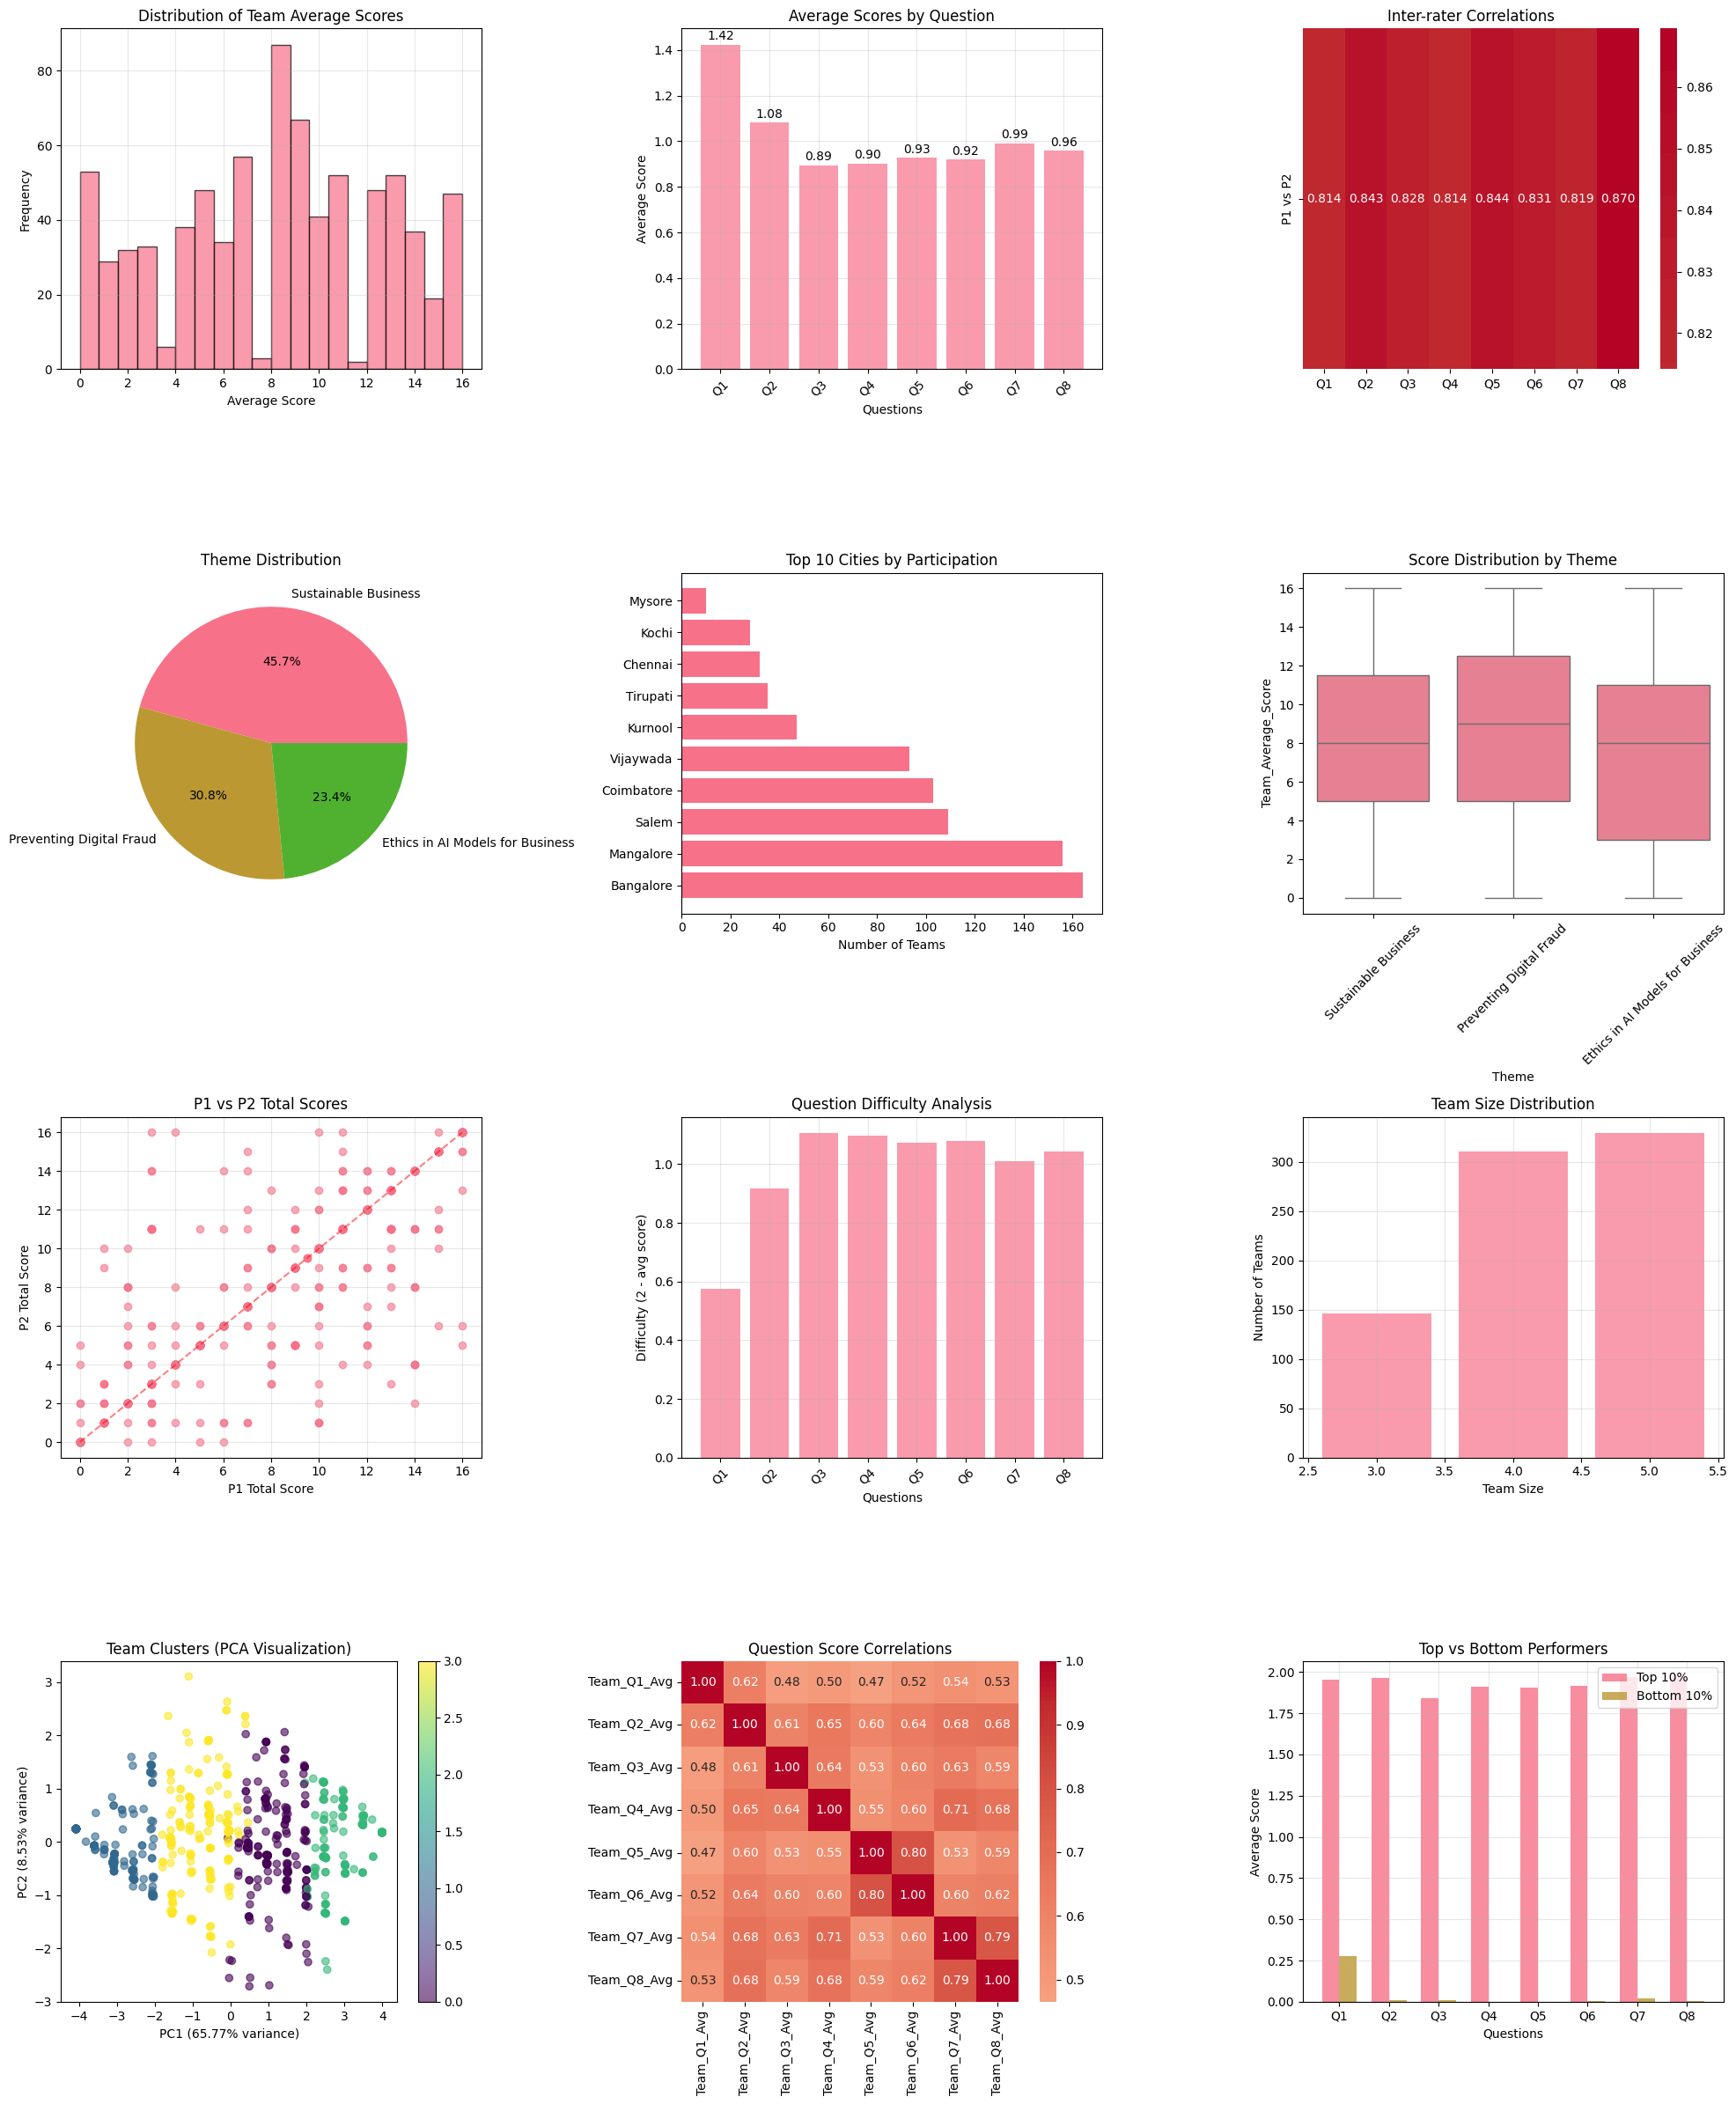

Comprehensive visualization saved as 'hackathon_analysis_comprehensive.png'

KEY INSIGHTS AND RECOMMENDATIONS
📊 PERFORMANCE INSIGHTS:
   • Average team performance: 8.10/2.0 (404.8%)
   • Performance variation: σ = 4.54
   • Strongest area: Q1 (Theme Relevance) - 1.42
   • Weakest area: Q3 (Originality) - 0.89

🤝 EVALUATION CONSISTENCY:
   • Average inter-rater correlation: 0.833
   • Excellent agreement between evaluators

🎯 THEME INSIGHTS:
   • Best performing theme: Preventing Digital Fraud (8.46)
   • Most challenging theme: Ethics in AI Models for Business (7.54)

🌍 PARTICIPATION INSIGHTS:
   • Total cities represented: 13
   • Highest participation: Bangalore (164 teams)
   • Total colleges represented: 30
   • Most active college: Manipal Institute of Technology (83 teams)

💡 RECOMMENDATIONS:
   1. Focus on improving teams' performance in: Originality
   2. Use high-performing teams as mentors for improvement areas
   4. Consider theme-specific workshops for challenging themes
 

True

In [94]:
analyzer.run_complete_analysis()

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

class HackathonAnalytics:
    """
    Comprehensive analytics toolkit for hackathon competition data.
    Designed to be modular and reusable across different datasets.
    """

    def __init__(self, csv_path):
        """Initialize with CSV data path."""
        self.df = pd.read_csv(csv_path)
        self.question_cols = [f'P{p}_Q{q}' for p in [1,2] for q in range(1,9)]
        self.prepare_data()

    def prepare_data(self):
        """Prepare and clean the data for analysis."""
        print("🧹 Cleaning and preparing data...")

        # Clean and convert question columns to numeric
        for p in [1, 2]:
            for q in range(1, 9):
                col = f'P{p}_Q{q}'
                if col in self.df.columns:
                    # Convert to numeric, replacing non-numeric values with NaN
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

                    # Fill NaN values with 0 (assuming missing scores are 0)
                    self.df[col] = self.df[col].fillna(0)

                    # Ensure values are in valid range (0-2)
                    self.df[col] = self.df[col].clip(0, 2)

        # Check for any remaining data issues
        question_cols = [f'P{p}_Q{q}' for p in [1,2] for q in range(1,9)]
        available_cols = [col for col in question_cols if col in self.df.columns]

        print(f"Found {len(available_cols)} out of {len(question_cols)} question columns")

        if len(available_cols) == 0:
            raise ValueError("No valid question columns found. Please check column names.")

        # Calculate aggregate scores only for available columns
        p1_cols = [col for col in available_cols if col.startswith('P1_')]
        p2_cols = [col for col in available_cols if col.startswith('P2_')]

        if len(p1_cols) > 0:
            self.df['P1_Total'] = self.df[p1_cols].sum(axis=1)
        else:
            self.df['P1_Total'] = 0

        if len(p2_cols) > 0:
            self.df['P2_Total'] = self.df[p2_cols].sum(axis=1)
        else:
            self.df['P2_Total'] = 0

        self.df['Average_Score'] = (self.df['P1_Total'] + self.df['P2_Total']) / 2
        self.df['Total_Score'] = self.df['P1_Total'] + self.df['P2_Total']

        # Calculate question-wise averages
        for q in range(1, 9):
            p1_col = f'P1_Q{q}'
            p2_col = f'P2_Q{q}'

            if p1_col in self.df.columns and p2_col in self.df.columns:
                self.df[f'Q{q}_Avg'] = (self.df[p1_col] + self.df[p2_col]) / 2
            elif p1_col in self.df.columns:
                self.df[f'Q{q}_Avg'] = self.df[p1_col]
            elif p2_col in self.df.columns:
                self.df[f'Q{q}_Avg'] = self.df[p2_col]
            else:
                self.df[f'Q{q}_Avg'] = 0

        # Score differences between evaluators
        self.df['Score_Difference'] = abs(self.df['P1_Total'] - self.df['P2_Total'])
        max_possible_diff = len(p1_cols) * 2  # Maximum possible difference
        self.df['Evaluator_Agreement'] = 1 - (self.df['Score_Difference'] / max_possible_diff) if max_possible_diff > 0 else 1

        # Clean text columns
        text_columns = ['Team_Name', 'City', 'College_Name', 'Department', 'Theme']
        for col in text_columns:
            if col in self.df.columns:
                self.df[col] = self.df[col].astype(str).str.strip()
                # Replace common missing value indicators
                self.df[col] = self.df[col].replace(['nan', 'NaN', 'null', 'None', ''], 'Unknown')

        # Clean numeric columns
        numeric_columns = ['Team_Size']
        for col in numeric_columns:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                self.df[col] = self.df[col].fillna(self.df[col].median())

        # Data quality report
        print(f"✅ Dataset loaded: {len(self.df)} teams")
        print(f"📊 Score range: {self.df['Total_Score'].min():.1f} - {self.df['Total_Score'].max():.1f}")
        print(f"📈 Average score: {self.df['Total_Score'].mean():.2f}")

        # Check for data quality issues
        if self.df['Total_Score'].std() == 0:
            print("⚠️ Warning: All teams have the same total score")

        missing_scores = self.df[available_cols].isnull().sum().sum()
        if missing_scores > 0:
            print(f"⚠️ Warning: {missing_scores} missing score values were filled with 0")

        print(f"🎯 Available themes: {self.df['Theme'].nunique()}")
        print(f"🏫 Available colleges: {self.df['College_Name'].nunique()}")
        print(f"🌍 Available cities: {self.df['City'].nunique()}")

    # 🎯 ADVANCED PERFORMANCE ANALYTICS

    def evaluator_bias_analysis(self):
        """Analyze evaluator harshness/leniency and scoring patterns."""
        print("="*50)
        print("🎯 EVALUATOR BIAS ANALYSIS")
        print("="*50)

        # Check if we have both evaluators
        if self.df['P1_Total'].sum() == 0 and self.df['P2_Total'].sum() == 0:
            print("⚠️ No evaluator data available for bias analysis")
            return None

        # Basic evaluator statistics
        p1_stats = {
            'mean': self.df['P1_Total'].mean(),
            'std': self.df['P1_Total'].std(),
            'median': self.df['P1_Total'].median(),
            'teams_evaluated': (self.df['P1_Total'] > 0).sum()
        }

        p2_stats = {
            'mean': self.df['P2_Total'].mean(),
            'std': self.df['P2_Total'].std(),
            'median': self.df['P2_Total'].median(),
            'teams_evaluated': (self.df['P2_Total'] > 0).sum()
        }

        print(f"P1 Statistics: Mean={p1_stats['mean']:.2f}, Std={p1_stats['std']:.2f}, Median={p1_stats['median']:.2f}")
        print(f"P1 Teams Evaluated: {p1_stats['teams_evaluated']}")
        print(f"P2 Statistics: Mean={p2_stats['mean']:.2f}, Std={p2_stats['std']:.2f}, Median={p2_stats['median']:.2f}")
        print(f"P2 Teams Evaluated: {p2_stats['teams_evaluated']}")

        # Statistical test for systematic bias (only if both evaluators have data)
        if p1_stats['teams_evaluated'] > 0 and p2_stats['teams_evaluated'] > 0:
            # Only compare teams that both evaluators scored
            both_evaluated = (self.df['P1_Total'] > 0) & (self.df['P2_Total'] > 0)

            if both_evaluated.sum() > 1:
                p1_scores = self.df.loc[both_evaluated, 'P1_Total']
                p2_scores = self.df.loc[both_evaluated, 'P2_Total']

                t_stat, p_value = stats.ttest_rel(p1_scores, p2_scores)
                print(f"\nSystematic Bias Test (Paired t-test on {both_evaluated.sum()} teams):")
                print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

                if p_value < 0.05:
                    if t_stat > 0:
                        print("🔍 P1 tends to score higher than P2 (statistically significant)")
                    else:
                        print("🔍 P2 tends to score higher than P1 (statistically significant)")
                else:
                    print("✅ No significant systematic bias detected")
            else:
                print("⚠️ Insufficient overlapping evaluations for bias testing")
                t_stat, p_value = None, None
        else:
            print("⚠️ Cannot perform bias analysis - insufficient evaluator data")
            t_stat, p_value = None, None

        # Question-wise evaluator differences
        print(f"\nQuestion-wise Evaluator Differences:")
        for q in range(1, 9):
            p1_col = f'P1_Q{q}'
            p2_col = f'P2_Q{q}'

            if p1_col in self.df.columns and p2_col in self.df.columns:
                p1_mean = self.df[p1_col].mean()
                p2_mean = self.df[p2_col].mean()
                diff = p1_mean - p2_mean
                print(f"Q{q}: {diff:+.3f} (P1: {p1_mean:.3f}, P2: {p2_mean:.3f})")

        return {'p1_stats': p1_stats, 'p2_stats': p2_stats, 'bias_test': (t_stat, p_value)}

    def halo_effect_analysis(self):
        """Detect halo effect in scoring patterns."""
        print("\n" + "="*50)
        print("✨ HALO EFFECT ANALYSIS")
        print("="*50)

        # Calculate correlations between questions for each evaluator
        questions = [f'Q{i}' for i in range(1, 9)]

        # For P1
        p1_corr_matrix = self.df[[f'P1_Q{i}' for i in range(1,9)]].corr()
        p1_avg_corr = p1_corr_matrix.values[np.triu_indices_from(p1_corr_matrix.values, k=1)].mean()

        # For P2
        p2_corr_matrix = self.df[[f'P2_Q{i}' for i in range(1,9)]].corr()
        p2_avg_corr = p2_corr_matrix.values[np.triu_indices_from(p2_corr_matrix.values, k=1)].mean()

        print(f"P1 Average Inter-Question Correlation: {p1_avg_corr:.3f}")
        print(f"P2 Average Inter-Question Correlation: {p2_avg_corr:.3f}")

        # High correlation might indicate halo effect
        halo_threshold = 0.7
        if p1_avg_corr > halo_threshold or p2_avg_corr > halo_threshold:
            print(f"🚨 Potential halo effect detected (correlation > {halo_threshold})")
        else:
            print(f"✅ Limited halo effect (correlation ≤ {halo_threshold})")

        return {'p1_corr': p1_avg_corr, 'p2_corr': p2_avg_corr}

    def question_interdependency_analysis(self):
        """Analyze which questions measure similar concepts."""
        print("\n" + "="*50)
        print("🔗 QUESTION INTERDEPENDENCY ANALYSIS")
        print("="*50)

        # Create average scores for each question
        q_scores = pd.DataFrame()
        for q in range(1, 9):
            q_scores[f'Q{q}'] = self.df[f'Q{q}_Avg']

        # Correlation matrix
        corr_matrix = q_scores.corr()
        print("Question Correlation Matrix:")
        print(corr_matrix.round(3))

        # Factor Analysis
        scaler = StandardScaler()
        scaled_scores = scaler.fit_transform(q_scores)

        fa = FactorAnalysis(n_components=3, random_state=42)
        fa.fit(scaled_scores)

        factor_loadings = pd.DataFrame(
            fa.components_.T,
            columns=['Factor1', 'Factor2', 'Factor3'],
            index=[f'Q{i}' for i in range(1,9)]
        )

        print(f"\nFactor Analysis Results:")
        print(factor_loadings.round(3))

        # Identify question groups
        print(f"\nQuestion Groups (based on highest factor loadings):")
        for i, factor in enumerate(['Factor1', 'Factor2', 'Factor3'], 1):
            top_questions = factor_loadings.nlargest(3, factor).index.tolist()
            print(f"Factor {i}: {top_questions}")

        return corr_matrix, factor_loadings

    def predictive_modeling(self):
        """Build model to predict success and identify key questions."""
        print("\n" + "="*50)
        print("🤖 PREDICTIVE MODELING")
        print("="*50)

        # Prepare features (average question scores)
        features = [f'Q{i}_Avg' for i in range(1, 9)]
        X = self.df[features]
        y = self.df['Total_Score']

        # Random Forest to identify important questions
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Feature importance
        importance_df = pd.DataFrame({
            'Question': features,
            'Importance': rf.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("Question Importance Ranking:")
        for _, row in importance_df.iterrows():
            print(f"{row['Question']}: {row['Importance']:.3f}")

        # Model performance
        y_pred = rf.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"\nModel Performance:")
        print(f"R² Score: {r2:.3f}")
        print(f"RMSE: {rmse:.3f}")

        # Top 3 predictive questions
        top_3_questions = importance_df.head(3)['Question'].tolist()
        print(f"\nTop 3 Predictive Questions: {top_3_questions}")

        return importance_df, r2, top_3_questions

    # 🏫 EDUCATIONAL INSTITUTION ANALYTICS

    def college_performance_analysis(self):
        """Analyze performance patterns by college and department."""
        print("\n" + "="*50)
        print("🏫 COLLEGE PERFORMANCE ANALYSIS")
        print("="*50)

        # Check if we have valid score data
        if self.df['Total_Score'].sum() == 0:
            print("⚠️ No valid scoring data available for analysis")
            return None, None

        # College performance summary
        college_stats = self.df.groupby('College_Name').agg({
            'Total_Score': ['mean', 'std', 'count'],
            'Q1_Avg': 'mean',  # Theme relevance
            'Q2_Avg': 'mean',  # Problem solving
            'Q3_Avg': 'mean',  # Originality
            'Q4_Avg': 'mean',  # Disruption potential
            'Q5_Avg': 'mean',  # Implementation feasibility
            'Q6_Avg': 'mean',  # Prototype feasibility
            'Q7_Avg': 'mean',  # Problem significance
            'Q8_Avg': 'mean'   # Long-term impact
        }).round(3)

        college_stats.columns = ['Avg_Score', 'Score_Std', 'Team_Count',
                               'Theme_Rel', 'Problem_Solve', 'Originality',
                               'Disruption', 'Impl_Feasible', 'Proto_Feasible',
                               'Problem_Sig', 'Long_Impact']

        # Filter colleges with at least 2 teams for meaningful analysis
        college_stats = college_stats[college_stats['Team_Count'] >= 2]

        if len(college_stats) == 0:
            print("⚠️ No colleges with multiple teams found for comparison")
            # Show all colleges anyway
            college_stats = self.df.groupby('College_Name').agg({
                'Total_Score': ['mean', 'count']
            }).round(3)
            college_stats.columns = ['Avg_Score', 'Team_Count']

        college_stats = college_stats.sort_values('Avg_Score', ascending=False)

        print("College Performance Analysis:")
        print(college_stats.head(10))

        # Department analysis
        if 'Department' in self.df.columns:
            dept_stats = self.df.groupby('Department').agg({
                'Total_Score': ['mean', 'std', 'count'],
                'Q3_Avg': 'mean',  # Originality
                'Q5_Avg': 'mean',  # Implementation
                'Q8_Avg': 'mean'   # Long-term impact
            }).round(3)

            dept_stats.columns = ['Avg_Score', 'Score_Std', 'Team_Count', 'Originality', 'Implementation', 'Long_Impact']
            dept_stats = dept_stats.sort_values('Avg_Score', ascending=False)

            print(f"\nDepartment Performance Analysis:")
            print(dept_stats)
        else:
            print("\n⚠️ Department column not found")
            dept_stats = None

        return college_stats, dept_stats

    def team_composition_analysis(self):
        """Analyze impact of team size and composition."""
        print("\n" + "="*50)
        print("👥 TEAM COMPOSITION ANALYSIS")
        print("="*50)

        # Team size analysis
        size_stats = self.df.groupby('Team_Size').agg({
            'Total_Score': ['mean', 'std', 'count'],
            'Q3_Avg': 'mean',  # Originality
            'Q5_Avg': 'mean'   # Feasibility
        }).round(3)

        size_stats.columns = ['Avg_Score', 'Score_Std', 'Team_Count', 'Originality', 'Feasibility']
        print("Performance by Team Size:")
        print(size_stats)

        # Find optimal team size
        optimal_size = size_stats['Avg_Score'].idxmax()
        print(f"\nOptimal Team Size: {optimal_size} (highest average score)")

        # Role diversity analysis (if roles are available)
        if 'P1_Role' in self.df.columns and 'P2_Role' in self.df.columns:
            # Check for diverse roles (different roles in team)
            self.df['Role_Diversity'] = (self.df['P1_Role'] != self.df['P2_Role']).astype(int)

            role_diversity_stats = self.df.groupby('Role_Diversity').agg({
                'Total_Score': ['mean', 'count']
            }).round(3)

            print(f"\nRole Diversity Impact:")
            print("0 = Same roles, 1 = Different roles")
            print(role_diversity_stats)

        return size_stats, optimal_size

    # 🌟 INNOVATION AND CREATIVITY METRICS

    def innovation_analysis(self):
        """Analyze innovation vs feasibility trade-offs."""
        print("\n" + "="*50)
        print("🌟 INNOVATION ANALYSIS")
        print("="*50)

        # Innovation vs Feasibility correlation
        innovation_feasibility_corr = pearsonr(self.df['Q3_Avg'], self.df['Q5_Avg'])
        print(f"Innovation vs Feasibility Correlation: {innovation_feasibility_corr[0]:.3f} (p={innovation_feasibility_corr[1]:.3f})")

        if innovation_feasibility_corr[0] < -0.3:
            print("🔍 Strong negative correlation: Highly original ideas tend to be less feasible")
        elif innovation_feasibility_corr[0] > 0.3:
            print("✅ Positive correlation: Original ideas can still be feasible")
        else:
            print("➡️ Weak correlation: Innovation and feasibility are relatively independent")

        # Create innovation profiles
        self.df['Innovation_Profile'] = 'Balanced'
        self.df.loc[(self.df['Q3_Avg'] >= 1.5) & (self.df['Q5_Avg'] < 1.0), 'Innovation_Profile'] = 'High Innovation, Low Feasibility'
        self.df.loc[(self.df['Q3_Avg'] < 1.0) & (self.df['Q5_Avg'] >= 1.5), 'Innovation_Profile'] = 'Low Innovation, High Feasibility'
        self.df.loc[(self.df['Q3_Avg'] >= 1.5) & (self.df['Q5_Avg'] >= 1.5), 'Innovation_Profile'] = 'High Innovation, High Feasibility'

        profile_stats = self.df.groupby('Innovation_Profile').agg({
            'Total_Score': ['mean', 'count'],
            'Q8_Avg': 'mean'  # Long-term impact
        }).round(3)

        print(f"\nInnovation Profiles:")
        print(profile_stats)

        # Theme innovation mapping
        theme_innovation = self.df.groupby('Theme').agg({
            'Q3_Avg': 'mean',  # Originality
            'Q4_Avg': 'mean',  # Disruption
            'Total_Score': 'mean',
            'Team_Name': 'count'
        }).round(3)

        theme_innovation.columns = ['Avg_Originality', 'Avg_Disruption', 'Avg_Score', 'Team_Count']
        theme_innovation = theme_innovation.sort_values('Avg_Originality', ascending=False)

        print(f"\nTheme Innovation Rankings:")
        print(theme_innovation)

        return innovation_feasibility_corr, profile_stats, theme_innovation

    def market_readiness_analysis(self):
        """Calculate market readiness index combining multiple factors."""
        print("\n" + "="*50)
        print("📈 MARKET READINESS ANALYSIS")
        print("="*50)

        # Market readiness index: weighted combination of feasibility, prototype, and disruption
        self.df['Market_Readiness'] = (
            0.4 * self.df['Q5_Avg'] +  # Implementation feasibility (40%)
            0.3 * self.df['Q6_Avg'] +  # Prototype feasibility (30%)
            0.3 * self.df['Q4_Avg']    # Disruption potential (30%)
        )

        # Categorize market readiness
        self.df['Readiness_Category'] = pd.cut(
            self.df['Market_Readiness'],
            bins=[0, 0.8, 1.4, 2.0],
            labels=['Low', 'Medium', 'High']
        )

        readiness_stats = self.df.groupby('Readiness_Category').agg({
            'Total_Score': ['mean', 'count'],
            'Q2_Avg': 'mean',  # Problem solving
            'Q7_Avg': 'mean',  # Problem significance
            'Q8_Avg': 'mean'   # Long-term impact
        }).round(3)

        print("Market Readiness Analysis:")
        print(readiness_stats)

        # Top market-ready teams
        top_ready = self.df.nlargest(10, 'Market_Readiness')[
            ['Team_Name', 'Theme', 'Market_Readiness', 'Total_Score']
        ]

        print(f"\nTop 10 Market-Ready Teams:")
        print(top_ready)

        return readiness_stats, top_ready

    # 📊 COMPETITIVE INTELLIGENCE

    def theme_analysis(self):
        """Comprehensive theme-based competitive analysis."""
        print("\n" + "="*50)
        print("📊 THEME COMPETITIVE ANALYSIS")
        print("="*50)

        theme_stats = self.df.groupby('Theme').agg({
            'Total_Score': ['mean', 'std', 'max', 'min', 'count'],
            'Q2_Avg': 'mean',  # Problem solving
            'Q3_Avg': 'mean',  # Originality
            'Q4_Avg': 'mean',  # Disruption
            'Q7_Avg': 'mean'   # Problem significance
        }).round(3)

        theme_stats.columns = ['Avg_Score', 'Score_Std', 'Max_Score', 'Min_Score', 'Team_Count',
                              'Problem_Solve', 'Originality', 'Disruption', 'Problem_Sig']

        # Calculate competition intensity
        theme_stats['Competition_Intensity'] = theme_stats['Team_Count'] / theme_stats['Score_Std']
        theme_stats['Blue_Ocean_Score'] = theme_stats['Avg_Score'] / theme_stats['Team_Count']  # High quality, low competition

        theme_stats = theme_stats.sort_values('Avg_Score', ascending=False)

        print("Theme Performance Summary:")
        print(theme_stats)

        # Identify blue ocean opportunities
        print(f"\nBlue Ocean Opportunities (High Quality, Low Competition):")
        blue_ocean = theme_stats.nlargest(5, 'Blue_Ocean_Score')[['Avg_Score', 'Team_Count', 'Blue_Ocean_Score']]
        print(blue_ocean)

        # Most competitive themes
        print(f"\nMost Competitive Themes:")
        competitive = theme_stats.nlargest(5, 'Team_Count')[['Avg_Score', 'Team_Count', 'Score_Std']]
        print(competitive)

        return theme_stats

    def geographic_analysis(self):
        """Analyze performance patterns by city/region."""
        print("\n" + "="*50)
        print("🌍 GEOGRAPHIC ANALYSIS")
        print("="*50)

        city_stats = self.df.groupby('City').agg({
            'Total_Score': ['mean', 'std', 'count'],
            'Q3_Avg': 'mean',  # Originality
            'Q4_Avg': 'mean',  # Disruption
            'College_Name': 'nunique'  # Number of different colleges
        }).round(3)

        city_stats.columns = ['Avg_Score', 'Score_Std', 'Team_Count', 'Originality', 'Disruption', 'College_Diversity']
        city_stats = city_stats[city_stats['Team_Count'] >= 2]  # Filter cities with multiple teams
        city_stats = city_stats.sort_values('Avg_Score', ascending=False)

        print("City Performance Analysis (≥2 teams):")
        print(city_stats.head(10))

        # Innovation hubs
        innovation_hubs = city_stats.nlargest(5, 'Originality')[['Avg_Score', 'Originality', 'Team_Count']]
        print(f"\nTop Innovation Hubs:")
        print(innovation_hubs)

        return city_stats

    # 🔮 ADVANCED ANALYTICS

    def clustering_analysis(self):
        """Cluster teams based on their scoring patterns."""
        print("\n" + "="*50)
        print("🔮 TEAM CLUSTERING ANALYSIS")
        print("="*50)

        # Prepare data for clustering
        features_for_clustering = [f'Q{i}_Avg' for i in range(1, 9)]
        X = self.df[features_for_clustering]

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        self.df['Cluster'] = kmeans.fit_predict(X_scaled)

        # Analyze clusters
        cluster_profiles = self.df.groupby('Cluster')[features_for_clustering + ['Total_Score']].mean().round(3)
        cluster_counts = self.df['Cluster'].value_counts().sort_index()

        print("Cluster Profiles:")
        print(cluster_profiles)
        print(f"\nCluster Sizes:")
        print(cluster_counts)

        # Name clusters based on characteristics
        cluster_names = {}
        for cluster_id in range(4):
            profile = cluster_profiles.loc[cluster_id]
            if profile['Q3_Avg'] >= 1.5 and profile['Q4_Avg'] >= 1.5:
                cluster_names[cluster_id] = "Innovation Leaders"
            elif profile['Q5_Avg'] >= 1.5 and profile['Q6_Avg'] >= 1.5:
                cluster_names[cluster_id] = "Implementation Masters"
            elif profile['Q2_Avg'] >= 1.5 and profile['Q7_Avg'] >= 1.5:
                cluster_names[cluster_id] = "Problem Solvers"
            else:
                cluster_names[cluster_id] = "Balanced Teams"

        print(f"\nCluster Interpretations:")
        for cluster_id, name in cluster_names.items():
            count = cluster_counts[cluster_id]
            avg_score = cluster_profiles.loc[cluster_id, 'Total_Score']
            print(f"Cluster {cluster_id}: {name} ({count} teams, avg score: {avg_score:.1f})")

        return cluster_profiles, cluster_names

    def comprehensive_scoring_analysis(self):
        """Comprehensive analysis of scoring patterns and agreement."""
        print("\n" + "="*50)
        print("📊 COMPREHENSIVE SCORING ANALYSIS")
        print("="*50)

        # Overall statistics
        print("Overall Scoring Statistics:")
        print(f"Average Total Score: {self.df['Total_Score'].mean():.2f} ± {self.df['Total_Score'].std():.2f}")
        print(f"Score Range: {self.df['Total_Score'].min():.0f} - {self.df['Total_Score'].max():.0f}")
        print(f"Average Evaluator Agreement: {self.df['Evaluator_Agreement'].mean():.3f}")

        # Question difficulty analysis
        print(f"\nQuestion Difficulty Analysis (lower average = harder):")
        question_difficulty = {}
        for q in range(1, 9):
            avg_score = self.df[f'Q{q}_Avg'].mean()
            question_difficulty[f'Q{q}'] = avg_score
            print(f"Q{q}: {avg_score:.3f}")

        # Most and least discriminating questions
        question_variance = {}
        for q in range(1, 9):
            variance = self.df[f'Q{q}_Avg'].std()
            question_variance[f'Q{q}'] = variance

        most_discriminating = max(question_variance, key=question_variance.get)
        least_discriminating = min(question_variance, key=question_variance.get)

        print(f"\nMost Discriminating Question: {most_discriminating} (std: {question_variance[most_discriminating]:.3f})")
        print(f"Least Discriminating Question: {least_discriminating} (std: {question_variance[least_discriminating]:.3f})")

        return question_difficulty, question_variance

    def generate_comprehensive_report(self):
        """Generate a complete analysis report."""
        print("\n" + "🎉" + "="*48 + "🎉")
        print("📋 COMPREHENSIVE HACKATHON ANALYTICS REPORT")
        print("🎉" + "="*48 + "🎉")

        # Run all analyses
        bias_results = self.evaluator_bias_analysis()
        halo_results = self.halo_effect_analysis()
        corr_matrix, factor_loadings = self.question_interdependency_analysis()
        importance_df, r2, top_questions = self.predictive_modeling()
        college_stats, dept_stats = self.college_performance_analysis()
        size_stats, optimal_size = self.team_composition_analysis()
        innovation_corr, profiles, theme_innovation = self.innovation_analysis()
        readiness_stats, top_ready = self.market_readiness_analysis()
        theme_stats = self.theme_analysis()
        city_stats = self.geographic_analysis()
        cluster_profiles, cluster_names = self.clustering_analysis()
        q_difficulty, q_variance = self.comprehensive_scoring_analysis()

        # Generate summary insights
        print(f"\n🎯 KEY INSIGHTS SUMMARY:")
        print(f"📊 Total Teams Analyzed: {len(self.df)}")
        print(f"🏆 Highest Scoring Team: {self.df.loc[self.df['Total_Score'].idxmax(), 'Team_Name']} ({self.df['Total_Score'].max():.1f} points)")
        print(f"👥 Optimal Team Size: {optimal_size}")
        print(f"🎯 Most Predictive Questions: {', '.join(top_questions[:3])}")
        print(f"🌟 Most Innovative Theme: {theme_innovation.index[0]}")
        print(f"💼 Top Market-Ready Team: {top_ready.iloc[0]['Team_Name']}")

        return {
            'bias_results': bias_results,
            'halo_results': halo_results,
            'correlation_matrix': corr_matrix,
            'factor_loadings': factor_loadings,
            'question_importance': importance_df,
            'model_r2': r2,
            'college_stats': college_stats,
            'department_stats': dept_stats,
            'team_size_stats': size_stats,
            'theme_stats': theme_stats,
            'city_stats': city_stats,
            'cluster_profiles': cluster_profiles,
            'innovation_analysis': (innovation_corr, profiles, theme_innovation),
            'market_readiness': (readiness_stats, top_ready)
        }

    def create_visualizations(self):
        """Create key visualizations for the analysis."""
        plt.style.use('default')
        sns.set_palette("husl")
        fig = plt.figure(figsize=(20, 24))

        # 1. Score Distribution
        plt.subplot(4, 3, 1)
        plt.hist(self.df['Total_Score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Total Score Distribution')
        plt.xlabel('Total Score')
        plt.ylabel('Frequency')

        # 2. Evaluator Agreement
        plt.subplot(4, 3, 2)
        plt.scatter(self.df['P1_Total'], self.df['P2_Total'], alpha=0.6)
        plt.plot([0, 16], [0, 16], 'r--', label='Perfect Agreement')
        plt.title('Evaluator Agreement')
        plt.xlabel('P1 Total Score')
        plt.ylabel('P2 Total Score')
        plt.legend()

        # 3. Question Difficulty
        plt.subplot(4, 3, 3)
        q_means = [self.df[f'Q{i}_Avg'].mean() for i in range(1, 9)]
        plt.bar(range(1, 9), q_means, color='lightcoral')
        plt.title('Question Difficulty (Average Scores)')
        plt.xlabel('Question Number')
        plt.ylabel('Average Score')
        plt.xticks(range(1, 9))

        # 4. Innovation vs Feasibility
        plt.subplot(4, 3, 4)
        plt.scatter(self.df['Q3_Avg'], self.df['Q5_Avg'],
                   c=self.df['Total_Score'], cmap='viridis', alpha=0.7)
        plt.colorbar(label='Total Score')
        plt.title('Innovation vs Feasibility')
        plt.xlabel('Originality (Q3)')
        plt.ylabel('Implementation Feasibility (Q5)')

        # 5. Team Size Performance
        plt.subplot(4, 3, 5)
        size_means = self.df.groupby('Team_Size')['Total_Score'].mean()
        plt.bar(size_means.index, size_means.values, color='gold')
        plt.title('Performance by Team Size')
        plt.xlabel('Team Size')
        plt.ylabel('Average Total Score')

        # 6. Theme Performance
        plt.subplot(4, 3, 6)
        theme_means = self.df.groupby('Theme')['Total_Score'].mean().sort_values(ascending=True)
        plt.barh(range(len(theme_means)), theme_means.values, color='mediumseagreen')
        plt.title('Performance by Theme')
        plt.xlabel('Average Total Score')
        plt.yticks(range(len(theme_means)), theme_means.index)

        # 7. Market Readiness Distribution
        plt.subplot(4, 3, 7)
        readiness_counts = self.df['Readiness_Category'].value_counts()
        plt.pie(readiness_counts.values, labels=readiness_counts.index, autopct='%1.1f%%',
                colors=['lightcoral', 'gold', 'lightgreen'])
        plt.title('Market Readiness Distribution')

        # 8. Question Correlation Heatmap
        plt.subplot(4, 3, 8)
        q_scores = pd.DataFrame()
        for q in range(1, 9):
            q_scores[f'Q{q}'] = self.df[f'Q{q}_Avg']
        corr_matrix = q_scores.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Question Correlation Matrix')

        # 9. Department Performance
        # plt.subplot(4, 3, 9)
        # dept_means = self.df.groupby('Department')['Total_Score'].mean().sort_values(ascending=True).head(5)
        # plt.barh(range(len(dept_means)), dept_means.values, color='mediumpurple')
        # plt.title('Performance by Department')
        # plt.xlabel('Average Total Score')
        # plt.yticks(range(len(dept_means)), dept_means.index)


        # 10. Evaluator Agreement vs Performance
        plt.subplot(4, 3, 10)
        plt.scatter(self.df['Evaluator_Agreement'], self.df['Total_Score'], alpha=0.6, color='orange')
        plt.title('Evaluator Agreement vs Performance')
        plt.xlabel('Evaluator Agreement')
        plt.ylabel('Total Score')

        # 11. Problem Significance vs Solution Impact
        plt.subplot(4, 3, 11)
        plt.scatter(self.df['Q7_Avg'], self.df['Q2_Avg'],
                   c=self.df['Q8_Avg'], cmap='plasma', alpha=0.7)
        plt.colorbar(label='Long-term Impact')
        plt.title('Problem Significance vs Solution Impact')
        plt.xlabel('Problem Significance (Q7)')
        plt.ylabel('Solution Impact (Q2)')

        # 12. Top Teams Radar Chart Data Preparation
        plt.subplot(4, 3, 12)
        top_5_teams = self.df.nlargest(5, 'Total_Score')
        questions = [f'Q{i}_Avg' for i in range(1, 9)]

        # Simple line plot showing top team profiles
        for idx, (_, team) in enumerate(top_5_teams.iterrows()):
            plt.plot(range(1, 9), [team[q] for q in questions],
                    marker='o', label=f"{team['Team_Name'][:15]}...")
        plt.title('Top 5 Teams - Performance Profile')
        plt.xlabel('Question Number')
        plt.ylabel('Average Score')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(range(1, 9))

        plt.tight_layout()
        plt.savefig('hackathon_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return fig

    def export_insights(self, filename='hackathon_insights.csv'):
        """Export key insights and derived metrics to CSV."""
        insights_df = self.df[[
            'UUID', 'Team_Name', 'Team_Size', 'City', 'College_Name',
            'Department', 'Theme', 'Total_Score', 'Average_Score',
            'Market_Readiness', 'Readiness_Category', 'Innovation_Profile',
            'Evaluator_Agreement', 'Cluster'
        ]].copy()

        # Add rankings
        insights_df['Overall_Rank'] = insights_df['Total_Score'].rank(ascending=False, method='min')
        insights_df['Market_Readiness_Rank'] = insights_df['Market_Readiness'].rank(ascending=False, method='min')

        insights_df.to_csv(filename, index=False)
        print(f"\n💾 Insights exported to {filename}")
        return insights_df

# 🚀 USAGE EXAMPLE AND MAIN EXECUTION
def run_complete_analysis(csv_path):
    """
    Run the complete hackathon analysis pipeline.

    Args:
        csv_path (str): Path to the CSV file containing hackathon data

    Returns:
        HackathonAnalytics: Initialized analytics object with all results
    """
    print("🚀 STARTING COMPREHENSIVE HACKATHON ANALYSIS")
    print("="*70)

    # Initialize analyzer
    analyzer = HackathonAnalytics(csv_path)

    # Run complete analysis
    results = analyzer.generate_comprehensive_report()

    # Create visualizations
    print(f"\n📊 Generating visualizations...")
    analyzer.create_visualizations()

    # Export insights
    insights_df = analyzer.export_insights()

    print(f"\n✅ Analysis complete! Check the generated visualizations and insights file.")

    return analyzer, results, insights_df

# 🔧 UTILITY FUNCTIONS FOR SPECIFIC ANALYSES

def quick_team_lookup(analyzer, team_name):
    """Quick lookup for specific team performance."""
    team_data = analyzer.df[analyzer.df['Team_Name'].str.contains(team_name, case=False, na=False)]
    if len(team_data) == 0:
        print(f"No team found matching '{team_name}'")
        return None

    team = team_data.iloc[0]
    print(f"\n🔍 TEAM ANALYSIS: {team['Team_Name']}")
    print(f"Theme: {team['Theme']}")
    print(f"College: {team['College_Name']}")
    print(f"Department: {team['Department']}")
    print(f"Team Size: {team['Team_Size']}")
    print(f"Total Score: {team['Total_Score']:.1f} (Rank: {team.get('Overall_Rank', 'N/A')})")
    print(f"Market Readiness: {team['Market_Readiness']:.2f}")
    print(f"Innovation Profile: {team['Innovation_Profile']}")

    # Question breakdown
    print(f"\nQuestion Scores (P1/P2/Avg):")
    for q in range(1, 9):
        p1_score = team[f'P1_Q{q}']
        p2_score = team[f'P2_Q{q}']
        avg_score = team[f'Q{q}_Avg']
        print(f"Q{q}: {p1_score}/{p2_score}/{avg_score:.1f}")

    return team_data

def compare_themes(analyzer, theme1, theme2):
    """Compare performance between two specific themes."""
    theme1_data = analyzer.df[analyzer.df['Theme'] == theme1]
    theme2_data = analyzer.df[analyzer.df['Theme'] == theme2]

    if len(theme1_data) == 0 or len(theme2_data) == 0:
        print("One or both themes not found in dataset")
        return None

    comparison = {
        'Theme': [theme1, theme2],
        'Team_Count': [len(theme1_data), len(theme2_data)],
        'Avg_Score': [theme1_data['Total_Score'].mean(), theme2_data['Total_Score'].mean()],
        'Avg_Innovation': [theme1_data['Q3_Avg'].mean(), theme2_data['Q3_Avg'].mean()],
        'Avg_Feasibility': [theme1_data['Q5_Avg'].mean(), theme2_data['Q5_Avg'].mean()],
        'Avg_Market_Readiness': [theme1_data['Market_Readiness'].mean(), theme2_data['Market_Readiness'].mean()]
    }

    comparison_df = pd.DataFrame(comparison)
    print(f"\n🆚 THEME COMPARISON: {theme1} vs {theme2}")
    print(comparison_df.round(3))

    return comparison_df

def identify_winning_patterns(analyzer):
    """Identify patterns among top-performing teams."""
    top_20_percent = int(len(analyzer.df) * 0.2)
    top_teams = analyzer.df.nlargest(top_20_percent, 'Total_Score')

    print(f"\n🏆 WINNING PATTERNS ANALYSIS (Top {top_20_percent} teams)")
    print("="*50)

    # Most common characteristics
    print("Most Common Themes among Winners:")
    print(top_teams['Theme'].value_counts().head())

    print(f"\nMost Common Departments among Winners:")
    print(top_teams['Department'].value_counts().head())

    print(f"\nMost Common Cities among Winners:")
    print(top_teams['City'].value_counts().head())

    print(f"\nAverage Team Size among Winners: {top_teams['Team_Size'].mean():.1f}")
    print(f"Most Common Team Size among Winners: {top_teams['Team_Size'].mode().iloc[0]}")

    # Key performance metrics
    print(f"\nKey Metrics for Top Performers:")
    for q in range(1, 9):
        avg_score = top_teams[f'Q{q}_Avg'].mean()
        print(f"Q{q} Average: {avg_score:.2f}")

    return top_teams

# 📚 QUESTION MAPPING FOR REFERENCE
QUESTION_MAPPING = {
    'Q1': 'Theme Relevance (0-2)',
    'Q2': 'Problem Solving Impact (0-2)',
    'Q3': 'Originality (0-2)',
    'Q4': 'Disruption Potential (0-2)',
    'Q5': 'Implementation Feasibility (0-2)',
    'Q6': 'Prototype Feasibility (0-2)',
    'Q7': 'Problem Significance (0-2)',
    'Q8': 'Long-term Impact (0-2)'
}

def print_question_reference():
    """Print the question mapping for reference."""
    print("\n📚 QUESTION REFERENCE:")
    print("="*30)
    for q_code, description in QUESTION_MAPPING.items():
        print(f"{q_code}: {description}")

# 🎯 MAIN EXECUTION WITH ERROR HANDLING
def safe_run_analysis(csv_path):
    """
    Safely run the complete hackathon analysis with proper error handling.

    Args:
        csv_path (str): Path to the CSV file containing hackathon data

    Returns:
        tuple: (analyzer, results, insights) or (None, None, None) if failed
    """
    try:
        print("🚀 STARTING COMPREHENSIVE HACKATHON ANALYSIS")
        print("="*70)

        # Check if file exists
        import os
        if not os.path.exists(csv_path):
            print(f"❌ Error: File '{csv_path}' not found")
            return None, None, None

        # Initialize analyzer with error handling
        try:
            analyzer = HackathonAnalytics(csv_path)
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            print("💡 Tip: Check that your CSV has the expected column names")
            return None, None, None

        # Run complete analysis
        try:
            results = analyzer.generate_comprehensive_report()
        except Exception as e:
            print(f"❌ Error during analysis: {e}")
            print("💡 Running individual analyses to identify the issue...")

            # Try each analysis individually to identify problematic ones
            try:
                analyzer.evaluator_bias_analysis()
            except Exception as e2:
                print(f"⚠️ Evaluator bias analysis failed: {e2}")

            try:
                analyzer.comprehensive_scoring_analysis()
            except Exception as e2:
                print(f"⚠️ Scoring analysis failed: {e2}")

            return analyzer, None, None

        # Create visualizations
        try:
            print(f"\n📊 Generating visualizations...")
            analyzer.create_visualizations()
        except Exception as e:
            print(f"⚠️ Visualization generation failed: {e}")
            print("💡 Analysis results are still available")

        # Export insights
        try:
            insights_df = analyzer.export_insights()
        except Exception as e:
            print(f"⚠️ Export failed: {e}")
            insights_df = None

        print(f"\n✅ Analysis complete!")

        return analyzer, results, insights_df

    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        print("💡 Please check your CSV file format and data quality")
        return None, None, None

def run_complete_analysis(csv_path):
    """
    Legacy function name for backward compatibility.
    """
    return safe_run_analysis(csv_path)

def diagnose_data_issues(csv_path):
    """
    Diagnose common data issues in the CSV file.

    Args:
        csv_path (str): Path to the CSV file
    """
    try:
        print("🔍 DIAGNOSING DATA ISSUES")
        print("="*30)

        # Load raw data
        df_raw = pd.read_csv(csv_path)
        print(f"✅ File loaded successfully: {len(df_raw)} rows, {len(df_raw.columns)} columns")

        # Check column names
        expected_patterns = ['UUID', 'Team_Name', 'P1_Q', 'P2_Q']
        found_patterns = []

        for pattern in expected_patterns:
            matching_cols = [col for col in df_raw.columns if pattern in col]
            found_patterns.append((pattern, len(matching_cols), matching_cols[:3]))

        print(f"\nColumn Pattern Analysis:")
        for pattern, count, examples in found_patterns:
            print(f"{pattern}: {count} columns (e.g., {examples})")

        # Check for question columns specifically
        question_cols = [col for col in df_raw.columns if col.startswith(('P1_Q', 'P2_Q'))]
        print(f"\nQuestion columns found: {len(question_cols)}")
        print(f"Sample question columns: {question_cols[:8]}")

        # Check data types in question columns
        if question_cols:
            print(f"\nData type issues in question columns:")
            for col in question_cols[:8]:  # Check first 8
                non_numeric = pd.to_numeric(df_raw[col], errors='coerce').isna().sum()
                unique_vals = df_raw[col].unique()[:10]  # First 10 unique values
                print(f"{col}: {non_numeric} non-numeric values, unique: {unique_vals}")

        # Check for missing values
        missing_summary = df_raw.isnull().sum()
        cols_with_missing = missing_summary[missing_summary > 0]

        if len(cols_with_missing) > 0:
            print(f"\nColumns with missing values:")
            print(cols_with_missing.head(10))
        else:
            print(f"\n✅ No missing values found")

        # Sample data preview
        print(f"\nSample data preview:")
        print(df_raw.head(3))

    except Exception as e:
        print(f"❌ Error reading file: {e}")
        print("💡 Make sure the file path is correct and the file is a valid CSV")

🚀 STARTING COMPREHENSIVE HACKATHON ANALYSIS
🧹 Cleaning and preparing data...
Found 16 out of 16 question columns
✅ Dataset loaded: 785 teams
📊 Score range: 0.0 - 32.0
📈 Average score: 16.19
🎯 Available themes: 3
🏫 Available colleges: 30
🌍 Available cities: 13

🎉================================================🎉
📋 COMPREHENSIVE HACKATHON ANALYTICS REPORT
🎉================================================🎉
🎯 EVALUATOR BIAS ANALYSIS
P1 Statistics: Mean=8.15, Std=4.72, Median=8.00
P1 Teams Evaluated: 728
P2 Statistics: Mean=8.04, Std=4.68, Median=8.00
P2 Teams Evaluated: 729

Systematic Bias Test (Paired t-test on 724 teams):
t-statistic: 1.365, p-value: 0.173
✅ No significant systematic bias detected

Question-wise Evaluator Differences:
Q1: +0.019 (P1: 1.433, P2: 1.414)
Q2: +0.034 (P1: 1.099, P2: 1.064)
Q3: +0.025 (P1: 0.907, P2: 0.882)
Q4: +0.018 (P1: 0.911, P2: 0.893)
Q5: +0.011 (P1: 0.932, P2: 0.921)
Q6: -0.008 (P1: 0.916, P2: 0.924)
Q7: -0.001 (P1: 0.989, P2: 0.990)
Q8: +0.019 (P1: 0.9

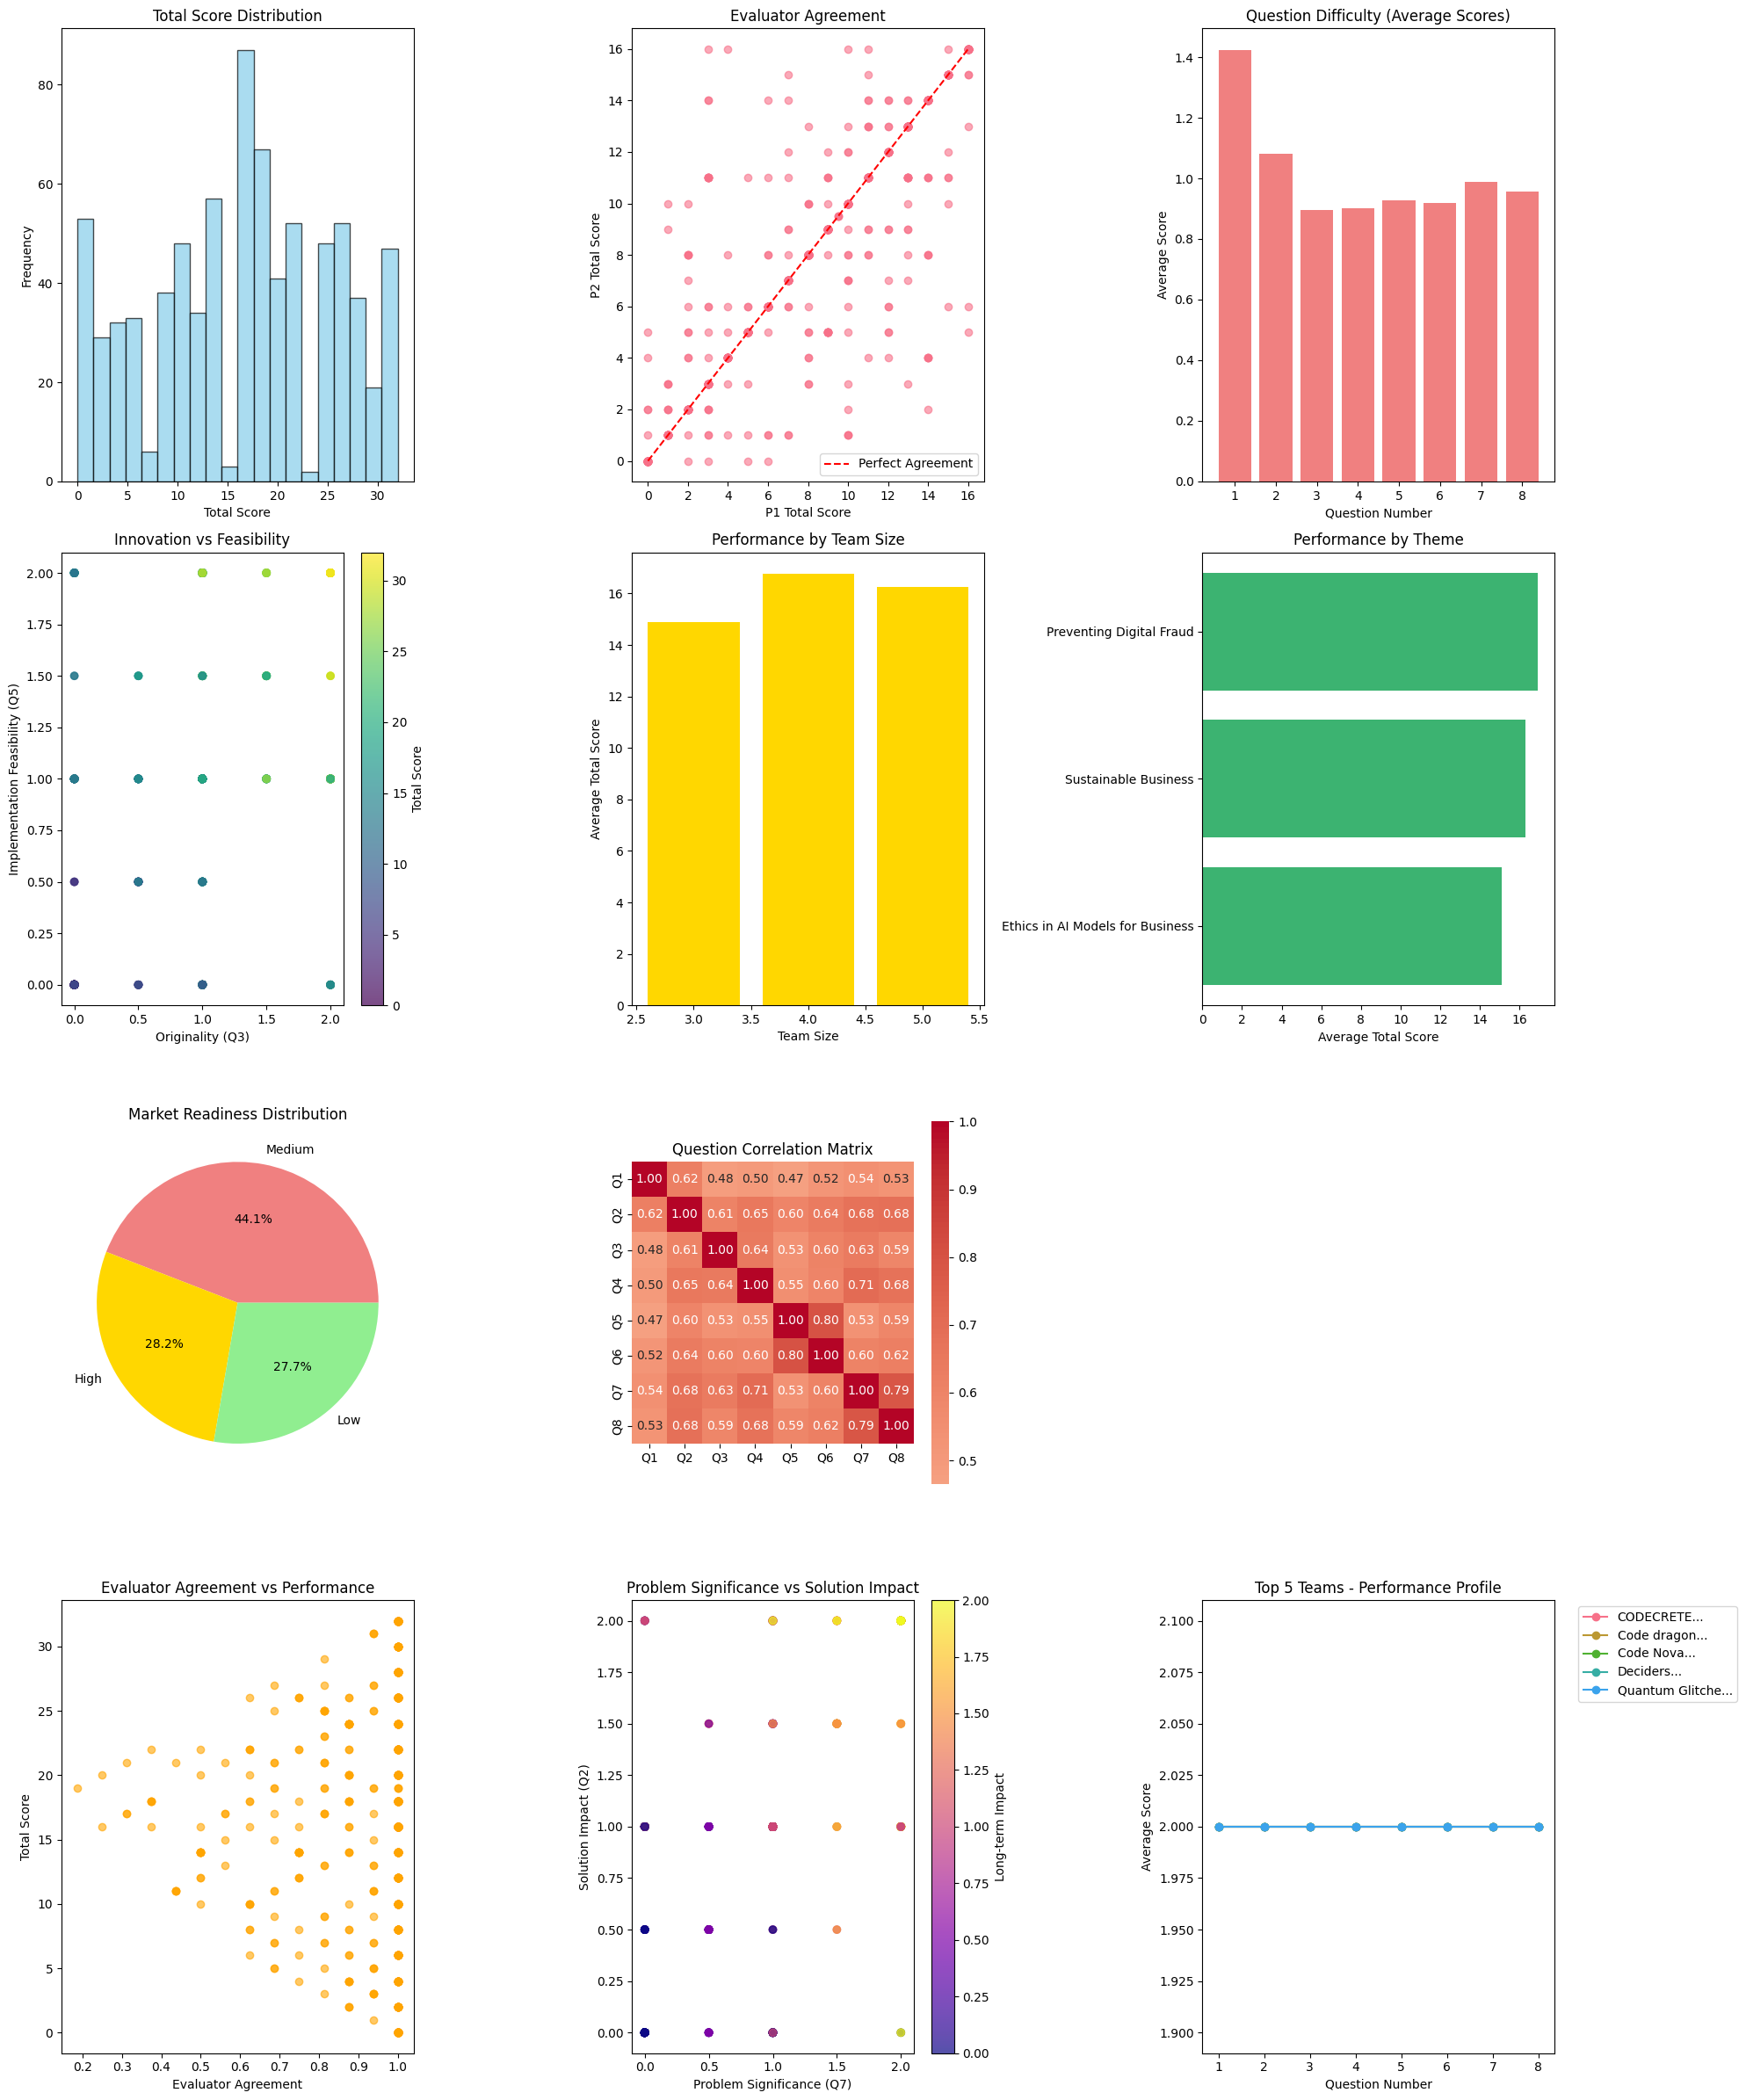


💾 Insights exported to hackathon_insights.csv

✅ Analysis complete!

🏆 WINNING PATTERNS ANALYSIS (Top 157 teams)
Most Common Themes among Winners:
Theme
Preventing Digital Fraud            61
Sustainable Business                60
Ethics in AI Models for Business    36
Name: count, dtype: int64

Most Common Departments among Winners:
Department
CSE                                 20
Computer Science and Engineering    14
Information Technology               8
ECE                                  5
COMPUTER SCIENCE AND ENGINEERING     4
Name: count, dtype: int64

Most Common Cities among Winners:
City
Bangalore     51
Mangalore     41
Salem         20
Coimbatore    10
Kochi         10
Name: count, dtype: int64

Average Team Size among Winners: 4.3
Most Common Team Size among Winners: 5

Key Metrics for Top Performers:
Q1 Average: 1.95
Q2 Average: 1.85
Q3 Average: 1.66
Q4 Average: 1.74
Q5 Average: 1.71
Q6 Average: 1.75
Q7 Average: 1.84
Q8 Average: 1.88


,Unnamed: 0,UUID,Team_Name,Team_Size,City,College_Name,Degree,Department,Theme,Ideal_Title,...,Q6_Avg,Q7_Avg,Q8_Avg,Score_Difference,Evaluator_Agreement,Role_Diversity,Innovation_Profile,Market_Readiness,Readiness_Category,Cluster
1,1,178_CODECRETE_Coimbatore_SKCOTE,CODECRETE,5,Coimbatore,Sri Krishna College of Technology,B.tech / B.E,CIVIL ENGINEERING,Sustainable Business,NaN,...,2.0,2.0,2.0,0.0,1.0000,1,"High Innovation, High Feasibility",2.00,High,2
8,8,336_Codedragon_Coimbatore_SKCOTE,Code dragon,5,Coimbatore,Sri Krishna College of Technology,B.tech / B.E,CSE,Sustainable Business,NaN,...,2.0,2.0,2.0,0.0,1.0000,1,"High Innovation, High Feasibility",2.00,High,2
10,10,341_CodeNova_Coimbatore_SKCOTE,Code Nova,5,Coimbatore,Sri Krishna College of Technology,B.tech / B.E,B .tech IT,Preventing Digital Fraud,NaN,...,2.0,2.0,2.0,0.0,1.0000,1,"High Innovation, High Feasibility",2.00,High,2
17,17,366_Deciders_Coimbatore_SKCOTE,Deciders,5,Coimbatore,Sri Krishna College of Technology,B.tech / B.E,Electrical and Electronics Engineering,Preventing Digital Fraud,NaN,...,2.0,2.0,2.0,0.0,1.0000,1,"High Innovation, High Feasibility",2.00,High,2
40,40,541_QuantumGlitchers_Tirupati_MUN,Quantum Glitchers,5,Tirupati,Mohanbabu University,B.tech / B.E,Artificial Intelligence and Machine Learning,Preventing Digital Fraud,NaN,...,2.0,2.0,2.0,0.0,1.0000,0,"High Innovation, High Feasibility",2.00,High,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,722,3330_BlazingFire_Mangalore_MIOTE,Blazing Fire,3,Mangalore,Manipal Institute of Technology,B.tech / B.E,Information and Communication Technology,Preventing Digital Fraud,NaN,...,2.0,2.0,1.0,0.0,1.0000,1,Balanced,1.60,High,2
723,723,3331_BlazingFire_Mangalore_MIOTE,Blazing Fire,3,Mangalore,Manipal Institute of Technology,B.tech / B.E,Information Technology,Preventing Digital Fraud,NaN,...,2.0,2.0,1.0,0.0,1.0000,1,Balanced,1.60,High,2
781,781,3476_HackU_Bangalore_AECO,HackU,4,Bangalore,AMC Engineering College,B.tech / B.E,CSE,Preventing Digital Fraud,NaN,...,2.0,2.0,1.5,2.0,0.8750,0,Balanced,1.45,High,2
152,152,992_IDEAX_Salem_MIOTE,IDEA X,4,Salem,Mahendra Institute of Technology,B.tech / B.E,ECE,Preventing Digital Fraud,NaN,...,1.5,2.0,2.0,1.0,0.9375,1,Balanced,1.15,Medium,2


In [96]:
# Basic usage - runs complete analysis
analyzer, results, insights = run_complete_analysis('merged_file.csv')

# Specific team analysis
# quick_team_lookup(analyzer, 'team_name')

# Compare two themes
# compare_themes(analyzer, 'AI/ML', 'Sustainability')

# Find winning patterns
identify_winning_patterns(analyzer)